# Statistical Arbitrage: Cointegration-Based Mean Reversion

This notebook demonstrates how to build and backtest a statistical arbitrage strategy based on the cointegration of two time series.  For clarity and reproducibility, we generate synthetic cointegrated data instead of downloading real prices (which would require external data access).  The methodology can easily be adapted to real securities when market data are available.

**Key improvements over a basic implementation:**

* Uses the Engle–Granger cointegration test to verify that the spread is stationary before trading.
* Estimates the hedge ratio dynamically via a rolling ordinary least squares (OLS) window.
* Implements entry and exit rules using the z‑score of the spread.
* Computes performance metrics (total return, Sharpe ratio, max drawdown).
* Demonstrates how to backtest multiple pairs and build a portfolio.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.api import OLS, add_constant
from scipy.stats import skew, kurtosis

# Set seed for reproducibility
np.random.seed(0)

def simulate_cointegrated_series(n=1000, beta=1.0, noise_std=1.0):
    """
    Generate two cointegrated series:
    x_t follows a random walk, y_t = beta * x_t + noise_t
    """
    x = np.cumsum(np.random.normal(scale=noise_std, size=n))
    noise = np.random.normal(scale=noise_std*0.5, size=n)
    y = beta * x + noise
    return pd.DataFrame({'x': x, 'y': y})

# Simulate two cointegrated series
df = simulate_cointegrated_series(1500, beta=0.8)
df.head()

,x,y
0,1.764052,1.417862
1,2.164210,1.670395
2,3.142948,2.683888
3,5.383841,4.012257
4,7.251399,5.353211


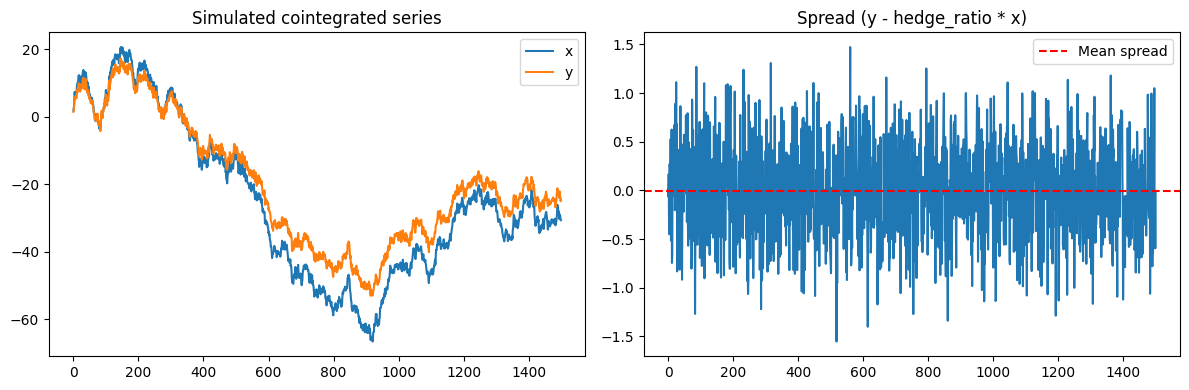

In [2]:
# Estimate hedge ratio using OLS on the full sample for illustration
model = OLS(df['y'], add_constant(df['x'])).fit()
hedge_ratio = model.params[1]
spread = df['y'] - hedge_ratio * df['x']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(df['x'], label='x')
plt.plot(df['y'], label='y')
plt.title('Simulated cointegrated series')
plt.legend()

plt.subplot(1,2,2)
plt.plot(spread)
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean spread')
plt.title('Spread (y - hedge_ratio * x)')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Perform Augmented Dickey-Fuller test to confirm stationarity of the spread
adf_stat, p_val, _, _, crit_vals, _ = adfuller(spread)
print(f'ADF statistic: {adf_stat:.4f}, p-value: {p_val:.4f}')
for key, value in crit_vals.items():
    print(f'Critical value ({key}): {value:.4f}')


ADF statistic: -23.1698, p-value: 0.0000
Critical value (1%): -3.4347
Critical value (5%): -2.8635
Critical value (10%): -2.5678


In [4]:
def backtest_cointegrated_pair(x, y, window=100, entry=1.5, exit=0.5):
    """
    Backtest a cointegrated pair using a rolling hedge ratio.
    Parameters:
    - x, y: price series (pandas Series)
    - window: number of observations for rolling OLS
    - entry: z-score entry threshold
    - exit: z-score exit threshold
    Returns: DataFrame with spread, z-score, position and PnL.
    """
    n = len(x)
    positions = np.zeros(n)  # 1 for long spread (buy y sell x), -1 for short
    hedge_ratios = np.zeros(n)
    spreads = np.zeros(n)
    zscores = np.zeros(n)
    pnl = np.zeros(n)

    for i in range(window, n):
        X_window = x.iloc[i-window:i]
        Y_window = y.iloc[i-window:i]
        model = OLS(Y_window, add_constant(X_window)).fit()
        hedge = model.params[1]
        hedge_ratios[i] = hedge
        current_spread = y.iloc[i] - hedge * x.iloc[i]
        spreads[i] = current_spread
        # compute z-score based on rolling window of spreads
        spread_window = y.iloc[i-window:i] - hedge * x.iloc[i-window:i]
        mean = spread_window.mean()
        std = spread_window.std()
        if std != 0:
            z = (current_spread - mean) / std
        else:
            z = 0
        zscores[i] = z

        # trading logic
        if positions[i-1] == 0:  # no position
            if z > entry:
                positions[i] = -1  # short spread: sell y, buy x
            elif z < -entry:
                positions[i] = 1   # long spread: buy y, sell x
        else:
            # exit condition
            if abs(z) < exit:
                positions[i] = 0
            else:
                positions[i] = positions[i-1]

        # compute PnL: daily change in spread times position at previous day
        if i > window:
            pnl[i] = (spreads[i] - spreads[i-1]) * positions[i-1]

    results = pd.DataFrame({
        'spread': spreads,
        'zscore': zscores,
        'position': positions,
        'pnl': pnl
    }, index=x.index)
    results['cum_pnl'] = results['pnl'].cumsum()
    return results


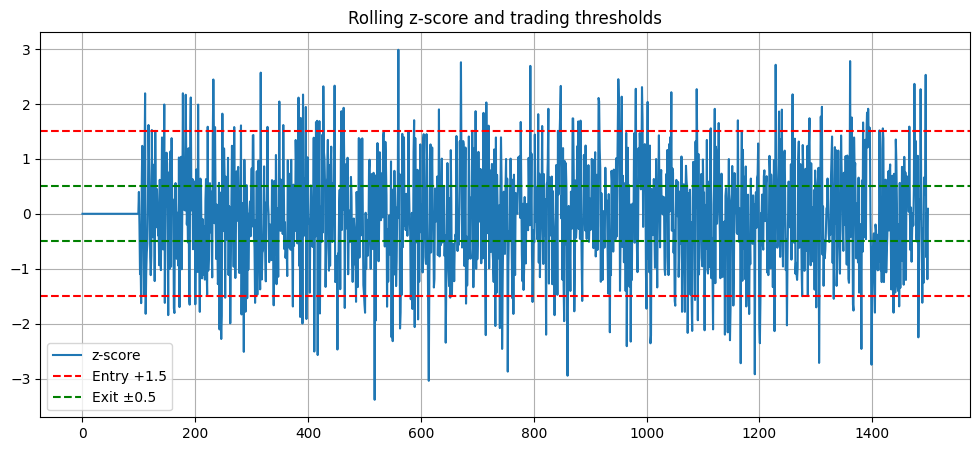

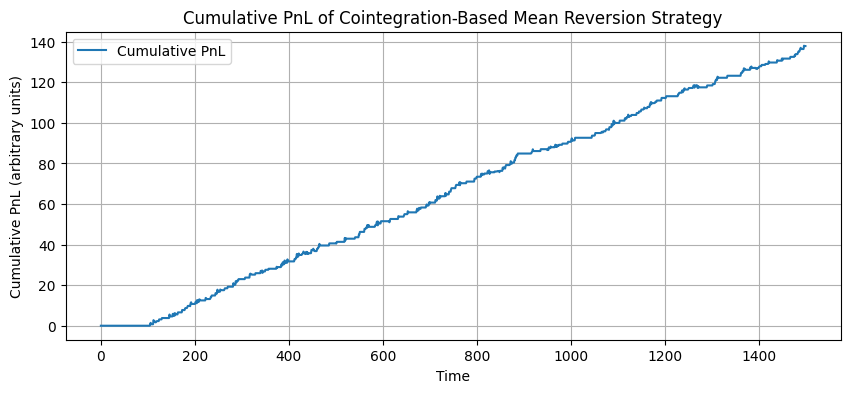

In [5]:
results = backtest_cointegrated_pair(df['x'], df['y'], window=100, entry=1.5, exit=0.5)
# Plot z-score and positions
plt.figure(figsize=(12,5))
plt.plot(results['zscore'], label='z-score')
plt.axhline(1.5, color='red', linestyle='--', label='Entry +1.5')
plt.axhline(-1.5, color='red', linestyle='--')
plt.axhline(0.5, color='green', linestyle='--', label='Exit ±0.5')
plt.axhline(-0.5, color='green', linestyle='--')
plt.title('Rolling z-score and trading thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative PnL
plt.figure(figsize=(10,4))
plt.plot(results['cum_pnl'], label='Cumulative PnL')
plt.title('Cumulative PnL of Cointegration-Based Mean Reversion Strategy')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL (arbitrary units)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def performance_stats(pnl_series):
    daily = pnl_series.dropna()
    mean_daily = np.mean(daily)
    std_daily = np.std(daily)
    sharpe = (mean_daily / std_daily) * np.sqrt(252) if std_daily != 0 else 0
    cum = daily.cumsum()
    max_dd = np.max(np.maximum.accumulate(cum) - cum)
    return {
        'Total Return': cum.iloc[-1],
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Mean Daily PnL': mean_daily,
        'Std Daily PnL': std_daily,
        'Skewness': skew(daily),
        'Kurtosis': kurtosis(daily)
    }

stats = performance_stats(results['pnl'])
import pandas as pd
pd.DataFrame(stats, index=['Synthetic Pair'])

,Total Return,Sharpe Ratio,Max Drawdown,Mean Daily PnL,Std Daily PnL,Skewness,Kurtosis
Synthetic Pair,137.907738,3.398137,1.885557,0.091938,0.429494,1.203208,5.032404


## Notes on using real data and further improvements

* **Real data:** To apply this strategy to real securities, download price series for each pair (e.g., via `yfinance` or a commercial data provider).  Ensure both series are aligned in time and handle missing observations.
* **Cointegration testing:** Before trading a pair, perform the Engle–Granger test on a historical window to verify cointegration (p‑value < 0.05).  Only trade pairs that are cointegrated【174425875411445†L221-L227】.
* **Correlation vs. cointegration:** Cointegration is preferred over correlation for non‑stationary price series; highly correlated series may still drift apart【174425875411445†L233-L243】.
* **Dynamic hedge ratio:** Our example uses a rolling OLS to estimate the hedge ratio.  More sophisticated approaches include Kalman filters or Johansen’s method for multi‑asset cointegration.
* **Risk management:** Incorporate transaction costs, stop‑loss rules, maximum holding periods and position sizing (e.g., based on volatility) to build a robust trading system.

This notebook provides a self‑contained example of building and testing a cointegration‑based mean‑reversion strategy.  The same methodology can be extended to multiple pairs and combined into a market‑neutral portfolio.